# Permanent Income Model using the DLE class

This notebook adds a third solution method for the linear-quadratic-Gaussian permanent income model
with $\beta R = 1$, complementing the other two solution methods shown in [this notebook](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/permanent_income.ipynb).

The new solution method uses the **DLE** class, which maps the permanent income model into the framework of Hansen & Sargent (2013) "Recursive Models of Dynamic Linear Economies".

In [1]:
import quantecon as qe
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from DynLinEcon import DLE

%matplotlib inline
np.set_printoptions(suppress=True, precision=4)

## The permanent income model


The LQ permanent income model  is an example of a 
``savings problem.''
  A consumer has preferences over consumption streams
that are ordered by
the utility functional

$$ E_0 \sum_{t=0}^\infty \beta^t u(c_t),  \quad(1) $$

where $E_t$ is the mathematical expectation conditioned
on the consumer's time $t$ information,  $c_t$ is time $t$ consumption,
$u(c)$ is a strictly concave one-period utility function, and
$\beta \in (0,1)$ is a discount factor.  The LQ model gets its name partly from assuming that the
utility function $u$ is quadratic:

$$ u(c) = -.5(c - \gamma)^2 $$

where $\gamma>0$ is a bliss level of consumption.

The consumer maximizes
the utility functional (1) by choosing a consumption, borrowing plan
 $\{c_t, b_{t+1}\}_{t=0}^\infty$ subject to the sequence of budget constraints
 
$$ c_t + b_t = R^{-1} b_{t+1}  + y_t, t \geq 0,  \quad(2)  $$

where $y_t$ is an exogenous
 stationary endowment process, $R$ is a constant gross
risk-free interest rate, $b_t$ is one-period risk-free  debt  maturing at
$t$, and $b_0$ is a given initial condition.  We shall assume
that $R^{-1} = \beta$. Equation (2) is linear.  We use another set of linear equations
to model the endowment process.  In particular, we assume that the endowment
process has the state-space representation

$$ \eqalign{ z_{t+1} & = A_{22} z_t + C_2 w_{t+1}  \cr
               y_t & = U_y  z_t  \cr} \quad (3) $$
               
where $w_{t+1}$ is an i.i.d. process with mean zero and
identity contemporaneous covariance matrix, $A_{22}$ is a stable matrix,
its eigenvalues being strictly below unity in modulus, and
$U_y$ is a selection vector that identifies $y$ with a particular
linear combination of the $z_t$.

We impose the following condition on the
consumption, borrowing plan:

$$ E_0 \sum_{t=0}^\infty \beta^t b_t^2 < +\infty. \quad (4) $$

This condition suffices to rule out Ponzi schemes. (We impose this condition to
rule out a borrow-more-and-more plan that would allow the household to
enjoy bliss consumption forever.)

The state vector confronting the household at $t$  is
$$ x_t = \left[\matrix{z_t \cr b_t\cr}\right],$$
where $b_t$ is its one-period debt falling
 due at the beginning of period $t$
and $z_t$ contains all variables useful for
forecasting its future endowment. 

We assume that $\{y_t\}$ follows a second order univariate autoregressive process:
$$ y_{t+1} = \alpha + \rho_1 y_t + \rho_2 y_{t-1} + \sigma w_{t+1} $$

### Solution method using the DLE class

One way of solving this model is to map the problem into the framework outlined in Section 4.8 of HS2013 by setting up our technology, information and preference matrices as follows:

Technology: $\phi_c=
  \left[ {\begin{array}{c}
   1 \\ 0
   \end{array} }
   \right]$,
$\phi_g=
  \left[ {\begin{array}{c}
   0 \\ 1
   \end{array} }
   \right]$,
$\phi_i=
  \left[ {\begin{array}{c}
   -1 \\ -0.00001
   \end{array} }
   \right]$,
$\Gamma=
  \left[ {\begin{array}{c}
   -1 \\ 0
   \end{array} }
   \right]$,
$\Delta_k = 0$, $\Theta_k = R$


Information: $A_{22} = \left[ {\begin{array}{ccc}
   1 & 0 & 0 \\ \alpha & \rho_1 & \rho_2 \\ 0 & 1 & 0
   \end{array} } 
   \right]$,
$C_{2} = \left[ {\begin{array}{c}
   0 \\ \sigma \\ 0
   \end{array} } 
   \right]$,
$U_b = \left[ {\begin{array}{ccc}
   \gamma & 0 & 0
   \end{array} } 
   \right]$,
$U_d = \left[ {\begin{array}{ccc}
   0 & 1 & 0 \\ 0 & 0 & 0
   \end{array} } 
   \right]$
   
Preferences: $\Lambda = 0$, $\Pi = 1$, $\Delta_h = 0$, $\Theta_h = 0$

We chose the same parameters as in the previous notebook. Specifically:

$\alpha = 10, \beta = 0.95, \rho_1 = 0.9, \rho_2 = 0, \sigma = 1$

(The value of $\gamma$ does not affect the optimal decision rule.)

The chosen matrices mean that the household's technology is:
$$ c_t + k_{t-1} = i_t + y_t$$
$$\frac{k_t}{R} = i_t$$
$$ l_t^2 = (0.00001)^2i_t $$

Combining the first two of these gives the budget constraint of the permanent income model, where $k_t = b_{t+1}$. The third equation is a very small penalty on debt-accumulation to rule out Ponzi schemes.

We set up this instance of the DLE class below:

In [2]:
alpha, beta, rho1, rho2, sigma = 10, 0.95, 0.9, 0, 1

gamma = np.array([[-1],[0]])
phic = np.array([[1],[0]])
phig = np.array([[0],[1]])
phi1 = 0.00001
phii = np.array([[-1],[-phi1]])
deltak = np.array([[0]])
thetak = np.array([[1/beta]])
beta = np.array([[beta]])
llambda = np.array([[0]])
pih = np.array([[1]])
deltah = np.array([[0]])
thetah = np.array([[0]])

a22 = np.array([[1,0,0],[alpha,rho1,rho2],[0,1,0]])
c2 = np.array([[0],[sigma],[0]])
ud = np.array([[0,1,0],[0,0,0]])
ub = np.array([[100,0,0]])

x0 = np.array([[0],[0],[1],[0],[0]])

Info1 = (a22,c2,ub,ud)
Tech1 = (phic,phig,phii,gamma,deltak,thetak)
Pref1 = (beta,llambda,pih,deltah,thetah)

Econ1 = DLE(Info1, Tech1, Pref1)

To check the solution of this model with that from the **LQ** problem, we select the $S_c$ matrix from the DLE class. The solution to the DLE economy has:
$$c_t = S_c x_t$$

In [3]:
Econ1.Sc

array([[  0.    ,  -0.05  ,  65.5172,   0.3448,   0.    ]])

The state vector in the DLE class is: 
$$
  x_t = \left[ {\begin{array}{c}
   h_{t-1} \\ k_{t-1} \\ z_t
   \end{array} }
   \right]$$
where $k_{t-1}$ = $b_{t}$ is set up to be $b_t$ in the permanent income model. 

The state vector in the LQ problem is
$\left[\matrix{z_t \cr b_t\cr}\right]$. Consequently, it is clear that the relevant elements of Econ1.Sc are the same as in -F from the previous notebook.

(see line 9 of that notebook for a print of the -F matrix)

The below plot quickly replicates the first two figures of that notebook, to confirm that the solutions are the same.

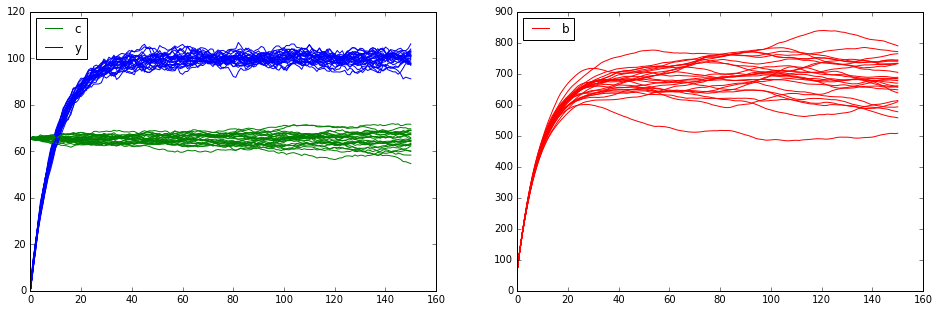

In [4]:
plt.figure(figsize=(16,5))
plt.subplot(121)

for i in range(25):
    Econ1.compute_sequence(x0,ts_length = 150)
    plt.plot(Econ1.c[0],color='g')
    plt.plot(Econ1.d[0],color='b')
plt.plot(Econ1.c[0],label='c',color='g')
plt.plot(Econ1.d[0],label='y',color='b')
plt.legend(loc='Best')

plt.subplot(122)

for i in range(25):
    Econ1.compute_sequence(x0,ts_length = 150)
    plt.plot(Econ1.k[0],color='r')
plt.plot(Econ1.k[0],label='b',color='r')
plt.legend(loc='Best')